In [73]:
%pylab inline

import pandas as pd

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import numpy as np

##### set up #######
sfams = ["Q%s"%ind for ind in range(1, 15)]
sizes = [1, -1, 2, -2, 4, -4, 8, -8, 10, -10, 15, 20, 25, 30]
sizefams = dict(zip(sfams, sizes))

cfams = ["F%s"%ind for ind in range(1, 13)]
covs = [1,1,5,5,10,10,20,20,30,30,50,50]
covfams = dict(zip(cfams, covs))

trs_per_fam = 10 # update to 100
covs = sorted(list(set(covs)))
thresh = 0.5


Populating the interactive namespace from numpy and matplotlib


In [113]:
# Load sizes
gref = pd.read_csv("hg38_ver17.bed", sep="\t", names=["chrom","pos","end","period"], usecols=range(4))
gref["reflen"] = gref.apply(lambda x: (x["end"]-x["pos"]+1)/x["period"], 1)
gref

,chrom,pos,end,period,reflen
0,chr15,17019727,17019738,3,4.0
1,chr15,17026436,17026447,1,12.0
2,chr15,17035572,17035583,3,4.0
3,chr15,17043558,17043569,3,4.0
4,chr15,17079695,17079706,3,4.0
...,...,...,...,...,...
1340261,chr14,106862486,106862497,4,3.0
1340262,chr14,106871601,106871612,4,3.0
1340263,chr14,106872606,106872617,4,3.0
1340264,chr14,106879224,106879236,1,13.0


In [132]:
data

,chrom,pos,period,prior,famid,sampid,phenotype,posterior,newallele,mutsize
0,chr1,37747553,1,0.001,F5,HealthyChild,1,1.333650e-05,0,0
1,chr1,37747553,1,0.001,F5,ProbandChild,2,4.623010e-06,0,0
2,chr1,37747771,3,0.001,F5,HealthyChild,1,1.943960e-07,0,0
3,chr1,37747771,3,0.001,F5,ProbandChild,2,2.902030e-06,0,0
4,chr1,37748919,1,0.001,F5,HealthyChild,1,2.603150e-05,0,0
...,...,...,...,...,...,...,...,...,...,...
1399,chr2,24305577,1,0.001,Q10,ProbandChild,2,4.181410e-16,0,0
1400,chr2,24306810,1,0.001,Q10,HealthyChild,1,2.598080e-16,0,0
1401,chr2,24306810,1,0.001,Q10,ProbandChild,2,4.408710e-17,0,0
1402,chr2,24307354,1,0.001,Q10,HealthyChild,1,5.410540e-17,0,0


In [141]:
def MutBarPlot(counts, xlabels, fname=None):
    # normalize counts to sum to 1
    for i in range(len(counts)):
        counts[i] = counts[i]/np.sum(counts[i])
    
    fig = plt.figure()
    fig.set_size_inches((6, 3))
    ax = fig.add_subplot(111)
    bottoms = [0]*len(xlabels)
    colors = ["red","black","gray"] # mut, nomut, nocall
    for i in range(len(counts[0])):
        ax.bar(range(len(counts)), [item[i] for item in counts], bottom=bottoms, color=colors[i])
        bottoms = [bottoms[j] + counts[j][i] for j in range(len(counts))]
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(xlabels)
    ax.set_ylabel("Number of loci")
    if fname is not None: fig.savefig(fname)
        
def PlotSimulations(method, covs, sizes, thresh, gref):
    if method == "naive":
        fname = "monstr_simulate_denovos.naive.all_mutations.txt"
    if method == "model":
        fname = "monstr_simulate_denovos.model.all_mutations.txt"
    data = pd.read_csv(fname, sep="\t",
                  names=["chrom","pos","period","prior","famid","sampid",
                        "phenotype","posterior","newallele","mutsize"], usecols=range(10))
    
    #### Infer loci we should use - should see at least one mutation. others 
    # probably weren't meant to be included
    useloci = data[data["posterior"]>=thresh][["chrom","pos"]].drop_duplicates().copy()

    print("Found %s loci"%useloci.shape[0])
    assert useloci.shape[0] == trs_per_fam
    useloci = pd.merge(useloci, gref, on=["chrom","pos"])
    print("Found %s loci after merge with gref"%useloci.shape[0])
    data = pd.merge(data, useloci, on=["chrom","pos"])
    
    ##### Coverage effects #####
    covdata = data[data["famid"].apply(lambda x: "F" in x)]
    covdata["coverage"] = covdata["famid"].apply(lambda x: covfams[x])

    proband_counts = []
    healthy_counts = []

    for c in covs:
        x_proband = covdata[(covdata["coverage"]==c) & (covdata["sampid"]=="ProbandChild")]
        x_healthy = covdata[(covdata["coverage"]==c) & (covdata["sampid"]=="HealthyChild")]
    
        # For proband
        num_proband_mut = x_proband[(x_proband["posterior"]>thresh)].shape[0]
        proband_counts.append([num_proband_mut, x_proband.shape[0]-num_proband_mut, useloci.shape[0]*2-x_proband.shape[0]])
    
        num_healthy_mut = x_healthy[(x_healthy["posterior"]>thresh)].shape[0]
        healthy_counts.append([num_healthy_mut, x_healthy.shape[0]-num_healthy_mut, useloci.shape[0]*2-x_healthy.shape[0]])

    # Gray=nocall, red=mutation called, black=no mutation called
    MutBarPlot(proband_counts, ["%sx"%item for item in covs], fname="%s-proband-bycov.pdf"%method)
    MutBarPlot(healthy_counts, ["%sx"%item for item in covs], fname="%s-healthy-bycov.pdf"%method)
    
    
    ##### Mutation size effects #####
    sizedata = data[data["famid"].apply(lambda x: "Q" in x)]
    sizedata["truesize"] = sizedata["famid"].apply(lambda x: sizefams[x])

    proband_counts = []

    thresh = 0.5

    sizes = sizes.copy()
    sizes.append(0)
    sizes.sort()
    for s in sizes:
        numtrs = useloci[useloci["reflen"]>=-1*s].shape[0]
        if s == 0:
            x_proband = sizedata[(sizedata["sampid"]=="HealthyChild") & (sizedata["famid"]=="Q1")] # chose a random family, healthychildren have no mutaiton, so size 0
        else:
            x_proband = sizedata[(sizedata["truesize"]==s) & (sizedata["sampid"]=="ProbandChild")]
        
        num_proband_mut = x_proband[(x_proband["posterior"]>thresh)].shape[0]
        proband_counts.append([num_proband_mut, x_proband.shape[0]-num_proband_mut, numtrs-x_proband.shape[0]])
    
    MutBarPlot(proband_counts, sizes, fname="%s-bysize-proband.pdf"%method)
    
    ##### Mutation size compare simulated vs. inferred #####
    fig = plt.figure()
    ax = fig.add_subplot(111)

    sizecounts = sizedata[(sizedata["sampid"]=="ProbandChild") & (sizedata["posterior"]>thresh)].groupby(["truesize","mutsize"], as_index=False).agg({"posterior": len})
    ax.scatter(sizecounts["truesize"], sizecounts["mutsize"], s=sizecounts["posterior"], edgecolor="black", color="white")
    ax.plot([-10,10],[-10,10], color="black", linewidth=0.5)
    ax.set_xlabel("True mutation size")
    ax.set_ylabel("Inferred mutation size")
    fig.savefig("%s-sizebubles.pdf"%method)
    
def PlotModelVsNaive(gref):
    naive = pd.read_csv("monstr_simulate_denovos.naive.all_mutations.txt", sep="\t",
                  names=["chrom","pos","period","prior","famid","sampid",
                        "phenotype","posterior","newallele","mutsize"], usecols=range(10))
    model = pd.read_csv("monstr_simulate_denovos.model.all_mutations.txt", sep="\t",
                  names=["chrom","pos","period","prior","famid","sampid",
                        "phenotype","posterior","newallele","mutsize"], usecols=range(10))

    useloci = naive[naive["posterior"]>=1][["chrom","pos"]].drop_duplicates().copy()
    useloci = pd.merge(useloci, gref, on=["chrom","pos"])

    # Choose only simulated loci
    naive = pd.merge(naive, useloci, on=["chrom","pos"])
    model = pd.merge(model, useloci, on=["chrom","pos"])
    
    # Choose all the "Q" data or "F" data
    naive = naive[naive["famid"].apply(lambda x: "F" in x)]
    model = model[model["famid"].apply(lambda x: "F" in x)]
    numfams = len(set(naive["famid"]))
    
    # Get counts
    proband_counts = []
    healthy_counts = []
    
    posts = [-1, 0.1, 0.5, 0.8, 0.9]
    for thresh in posts:
        if thresh == -1:
            x_proband = naive[(naive["sampid"]=="ProbandChild")]
            x_healthy = naive[(naive["sampid"]=="HealthyChild")]
            num_healthy_mut = x_healthy[(x_healthy["posterior"]>=1)].shape[0]
            num_proband_mut = x_proband[(x_proband["posterior"]>=1)].shape[0]
        else:
            x_proband = model[(model["sampid"]=="ProbandChild")]
            x_healthy = model[(model["sampid"]=="HealthyChild")]
            num_healthy_mut = x_healthy[(x_healthy["posterior"]>=thresh)].shape[0]
            num_proband_mut = x_proband[(x_proband["posterior"]>=thresh)].shape[0]
            
        proband_counts.append([num_proband_mut, x_proband.shape[0]-num_proband_mut, useloci.shape[0]*numfams-x_proband.shape[0]])
        healthy_counts.append([num_healthy_mut, x_healthy.shape[0]-num_healthy_mut, useloci.shape[0]*numfams-x_healthy.shape[0]])

    posts[0] = "Naive"
    MutBarPlot(proband_counts, posts, fname="%s-bypost-proband.pdf"%method)
    MutBarPlot(healthy_counts, posts, fname="%s-bypost-healthy.pdf"%method)

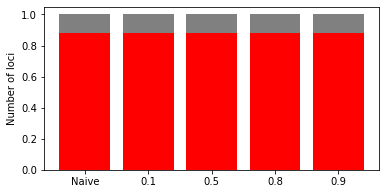

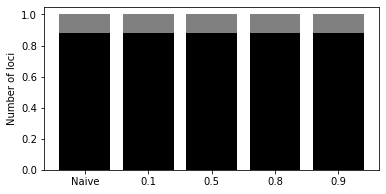

In [142]:
PlotModelVsNaive(gref)

Found 10 loci
Found 9 loci after merge with gref


<ipython-input-133-3b1afd27ff47>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covdata["coverage"] = covdata["famid"].apply(lambda x: covfams[x])
<ipython-input-133-3b1afd27ff47>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizedata["truesize"] = sizedata["famid"].apply(lambda x: sizefams[x])


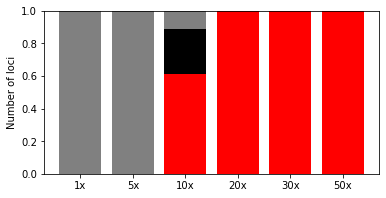

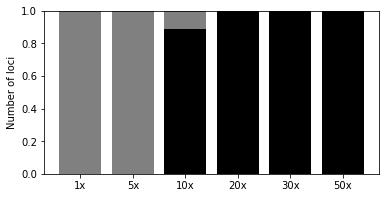

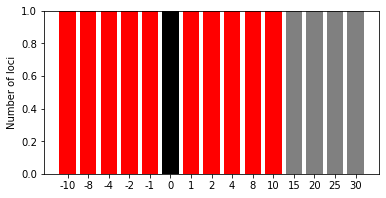

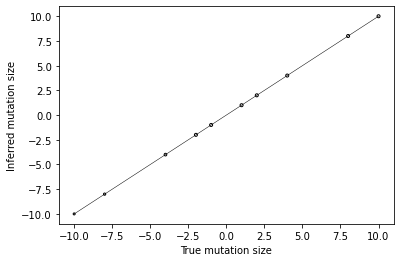

In [135]:
PlotSimulations("naive", covs, sizes, thresh, gref)

Found 10 loci
Found 9 loci after merge with gref


<ipython-input-133-3b1afd27ff47>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covdata["coverage"] = covdata["famid"].apply(lambda x: covfams[x])
<ipython-input-133-3b1afd27ff47>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizedata["truesize"] = sizedata["famid"].apply(lambda x: sizefams[x])


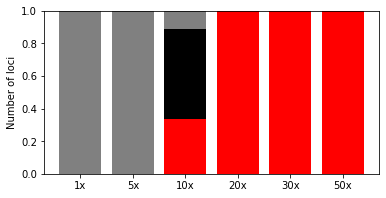

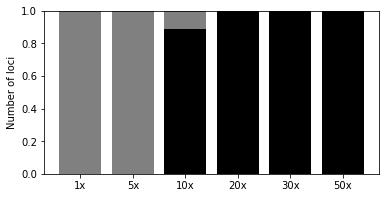

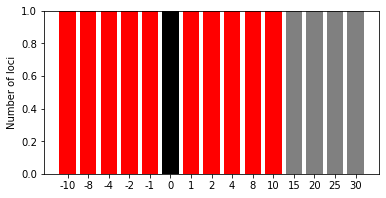

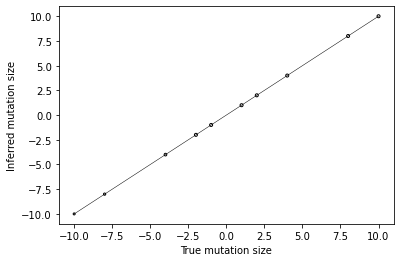

In [136]:
PlotSimulations("model", covs, sizes, 0.5, gref)